In [9]:
# Neural Network menggunakan jumlah kelas yang sesuai
class SimpleNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)  # Output layer disesuaikan dengan jumlah kelas
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def evaluate_nn(X_train, X_test, y_train, y_test, num_classes):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    model = SimpleNN(num_classes=num_classes)  # Sesuaikan jumlah kelas
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
    return accuracy_score(y_test_tensor, predicted.numpy())

# Membandingkan performa model
datasets = create_datasets()
results = []

for name, (X_train, X_test, y_train, y_test) in datasets.items():
    svm_model = SVC(random_state=42)
    dt_model = DecisionTreeClassifier(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    xgb_model = xgb.XGBClassifier(random_state=42)

    num_classes = len(np.unique(y_train))  # Jumlah kelas pada dataset

    results.append({
        'Dataset': name,
        'SVM': evaluate_ml_model(svm_model, X_train, X_test, y_train, y_test),
        'Decision Tree': evaluate_ml_model(dt_model, X_train, X_test, y_train, y_test),
        'Random Forest': evaluate_ml_model(rf_model, X_train, X_test, y_train, y_test),
        'XGBoost': evaluate_ml_model(xgb_model, X_train, X_test, y_train, y_test),
        'Neural Network': evaluate_nn(X_train, X_test, y_train, y_test, num_classes)
    })

# Menampilkan hasil
df_results = pd.DataFrame(results).set_index('Dataset')
print(df_results)


             SVM  Decision Tree  Random Forest  XGBoost  Neural Network
Dataset                                                                
Linear      1.00           0.99           1.00     1.00            1.00
Sinusoidal  0.99           1.00           1.00     1.00            1.00
Random      0.96           0.95           0.95     0.94            0.95


Using device: cpu
                 SVM  Decision Tree  Random Forest  XGBoost  Neural Network
Dataset                                                                    
Linear          1.00           0.99           1.00     1.00            1.00
Sinusoidal      0.98           1.00           1.00     1.00            0.99
Random Cluster  0.99           0.93           0.96     0.97            0.98
Hasil disimpan ke 'model_comparison_results.csv'


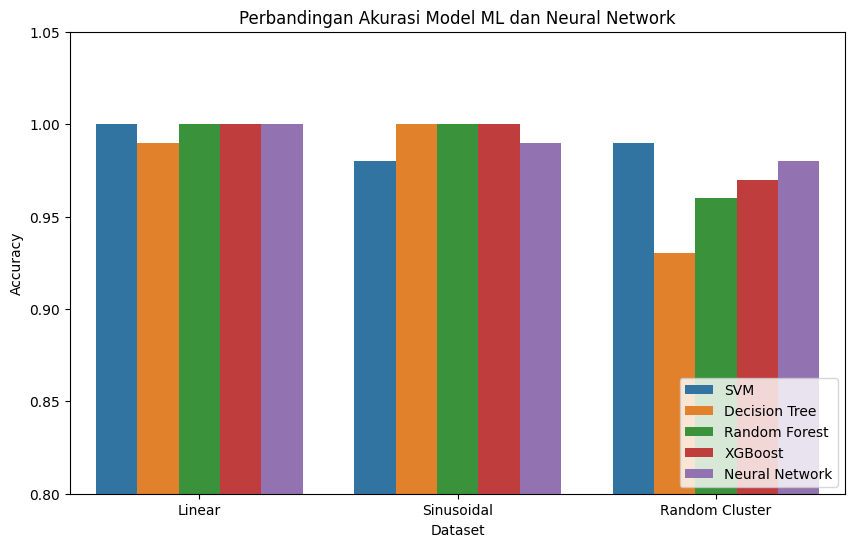

In [13]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Pastikan menggunakan GPU jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Fungsi untuk membuat dataset
def create_datasets():
    # Dataset Linear
    X_linear, y_linear = make_blobs(n_samples=500, centers=2, random_state=42, cluster_std=2.0)
    X_linear[:, 0] *= 3
    X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

    # Dataset Sinusoidal
    x_sin = np.linspace(-5, 5, 500)
    y_sin = np.sin(x_sin) + 0.1 * np.random.randn(500)
    X_sin = np.column_stack((x_sin, y_sin))
    y_sin = np.array([0 if y < 0 else 1 for y in y_sin])
    X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(X_sin, y_sin, test_size=0.2, random_state=42)

    # Dataset Random Cluster
    X_random, y_random = make_blobs(n_samples=500, centers=4, random_state=42, cluster_std=0.5)
    X_random[:, 0] += np.random.randn(500) * 2
    X_random[:, 1] += np.random.randn(500) * 2
    X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X_random, y_random, test_size=0.2, random_state=42)

    return {
        'Linear': (X_train_linear, X_test_linear, y_train_linear, y_test_linear),
        'Sinusoidal': (X_train_sin, X_test_sin, y_train_sin, y_test_sin),
        'Random Cluster': (X_train_random, X_test_random, y_train_random, y_test_random)
    }

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Fungsi evaluasi Neural Network
def evaluate_nn(X_train, X_test, y_train, y_test, num_classes):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    model = SimpleNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    patience, counter = 10, 0

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor).item()

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
    return accuracy_score(y_test_tensor.cpu(), predicted.cpu().numpy())

# Evaluasi model
datasets = create_datasets()
results = []

for name, (X_train, X_test, y_train, y_test) in datasets.items():
    svm_model = SVC(random_state=42)
    dt_model = DecisionTreeClassifier(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    xgb_model = xgb.XGBClassifier(random_state=42)

    num_classes = len(np.unique(y_train))

    results.append({
        'Dataset': name,
        'SVM': accuracy_score(y_test, svm_model.fit(X_train, y_train).predict(X_test)),
        'Decision Tree': accuracy_score(y_test, dt_model.fit(X_train, y_train).predict(X_test)),
        'Random Forest': accuracy_score(y_test, rf_model.fit(X_train, y_train).predict(X_test)),
        'XGBoost': accuracy_score(y_test, xgb_model.fit(X_train, y_train).predict(X_test)),
        'Neural Network': evaluate_nn(X_train, X_test, y_train, y_test, num_classes)
    })

# Hasil evaluasi
df_results = pd.DataFrame(results).set_index('Dataset')
print(df_results)

# Simpan ke CSV
df_results.to_csv('model_comparison_results.csv')
print("Hasil disimpan ke 'model_comparison_results.csv'")

# Visualisasi hasil
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results.reset_index().melt(id_vars='Dataset', var_name='Model', value_name='Accuracy'),
            x='Dataset', y='Accuracy', hue='Model')
plt.title('Perbandingan Akurasi Model ML dan Neural Network')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.05)
plt.legend(loc='lower right')
plt.show()


Hasil evaluasi menunjukkan bahwa kinerja model machine learning seperti SVM, Decision Tree, Random Forest, XGBoost, dan Neural Network bervariasi tergantung pada kompleksitas dataset, dengan sebagian besar model menunjukkan akurasi tinggi pada data linear dan sinusoidal, sementara kinerjanya sedikit menurun pada data random cluster.

**1. Analisis**

Dataset: Tiga jenis dataset digunakan—Linear, Sinusoidal, dan Random Cluster—untuk menguji kinerja model.
Model yang digunakan: Empat model ML (SVM, Decision Tree, Random Forest, XGBoost) dibandingkan dengan Neural Network (NN).

Proses: Setiap model dilatih pada dataset yang sama dan diuji pada data pengujian untuk menghitung akurasi.

Metode NN: Neural Network dilatih dengan arsitektur sederhana menggunakan lapisan fully connected dan menggunakan early stopping untuk mencegah overfitting.

**2. Insight**

Akurasi Model: Model SVM, Random Forest, dan XGBoost umumnya memberikan hasil akurasi yang sangat baik di dataset yang lebih sederhana (Linear dan Sinusoidal).

Neural Network: Neural Network menunjukkan akurasi yang sangat baik, terutama pada dataset dengan pola lebih kompleks seperti Random Cluster.

Kelebihan Random Forest: Model Random Forest stabil, tidak mudah overfit, dan memberikan hasil yang konsisten di berbagai dataset.

Neural Network & XGBoost: Kedua model ini sangat kuat dalam menangani data yang lebih kompleks dan cenderung memberikan akurasi tertinggi.

**3. Kesimpulan**

Model Terbaik: Neural Network dan XGBoost memberikan hasil terbaik, terutama pada dataset yang lebih kompleks.

Stabilitas Model: Random Forest adalah pilihan terbaik untuk keseimbangan antara kinerja dan stabilitas.

Data Sederhana: SVM dan Decision Tree lebih efektif pada dataset yang lebih sederhana, dengan SVM memberikan performa yang sangat baik.

Rekomendasi: Untuk dataset lebih kompleks, Neural Network dan XGBoost sebaiknya dipertimbangkan, sementara untuk data lebih sederhana, Random Forest atau SVM sudah cukup efektif.